# Flat bands in graphene adatom system.


Here, we generate a tight-binding model that reproduces low-energy band structure of a system that consists of graphene with periodically distributed adatoms placed on top.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import block_diag
import itertools
import matplotlib.path as mpltPath
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [7]:

#model parameters for topological-phase
onsite = 0.
dx_onsite = -0.1
dy_onsite = -0.1
dxsqrt_onsite = -1.2
dxy_onsite = -1.2
tdsqrt = -0.5
delta = 2.5
t = -2.0
td = 0.4
en_fermi = 0.071


'''
#without adatom: should reproduce pure graphene
onsite = 0.
dx_onsite = 0.
dy_onsite = 0.
dxsqrt_onsite = 0.
dxy_onsite = 0.
tdsqrt = 0.
delta = 0.
t = -2.0
td = 0.
en_fermi = 0.071
'''

'''
#trivial-phase
onsite = 0.5
dx_onsite = -0.1
dy_onsite = -0.1
dxsqrt_onsite = -1.2
dxy_onsite = -1.2
tdsqrt = -1.7
delta = 0.4
t = -2.0
td = 0.1
en_fermi = 0.071
'''

'\n#trivial-phase\nonsite = 0.5\ndx_onsite = -0.1\ndy_onsite = -0.1\ndxsqrt_onsite = -1.2\ndxy_onsite = -1.2\ntdsqrt = -1.7\ndelta = 0.4\nt = -2.0\ntd = 0.1\nen_fermi = 0.071\n'

In [8]:

#original graphene lattice vectors
lat = np.array([[3./2.,-np.sqrt(3.)/2.],[3./2.,np.sqrt(3.)/2.]])

#define coordinates of two pz orbitals in unit cell
orb = np.array([[1./3.,1./3.],[2./3.,2./3.]])


#defines the unit cell itself reasonable are of the form vec = [n, 3m+n]
vec = [-1,5]

#defines the number of unit cells for the graphene flake
levels = 4


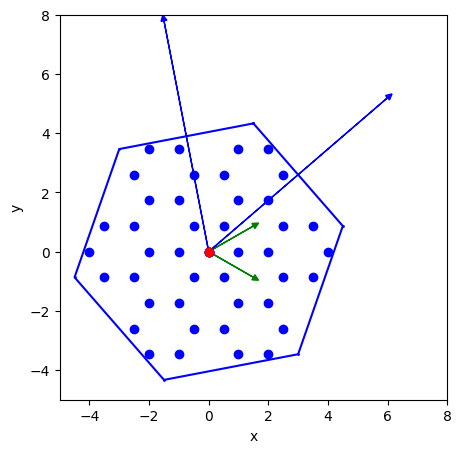

In [10]:
def super_hexagon(vec):
    vec2=[-vec[1],vec[1]+vec[0]]
    return [vec,vec2]
coef = super_hexagon(vec)
mega_lat = np.dot(coef,lat)
imp_loc = np.array([0.,0.])


#make a grid
expand = list(itertools.product(np.arange(-10,10,1), np.arange(-10,10,1)))
grid = []
for lat_vec in expand:
    for orbit in orb:
        tmp = orbit + lat_vec
        grid.append(np.array(tmp))



def cartez_coord(point,lat_vecs):
    x_val = np.array(point[0]*lat_vecs[0,0]+point[1]*lat_vecs[1,0])
    y_val = np.array(point[0]*lat_vecs[0,1]+point[1]*lat_vecs[1,1])
    return np.array([x_val,y_val])



cartez_grid = [cartez_coord(point,lat) for point in grid]
unit_hex = np.array([[1/3,1/3],[-1/3,2/3],[-2/3,1/3],[-1/3,-1/3],[1/3,-2/3],[2/3,-1/3],[1/3,1/3]])
hex_loc  = [cartez_coord(i,mega_lat) for i in unit_hex]
path_hex = mpltPath.Path(hex_loc)



def insider_check(pnt, path , ends):
    if path.contains_points([pnt],radius = 1e-9) == True:
        return True
    else:
        return False

list_inside   = []
for gen_point in grid:
    if insider_check(cartez_coord(gen_point,lat), path_hex, hex_loc) == True:
        list_inside.append(gen_point)
list_inside.append(np.array([0.,0.]))
list_inside.append(np.array([0.,0.]))
list_inside.append(np.array([0.,0.]))
list_inside.append(np.array([0.,0.]))

inside_hexagon  = np.array(list_inside)
inside          = [cartez_coord(point,lat) for point in inside_hexagon]


#this shows unit cell
def unit_cell_drawer(grid):
    fig,ax = plt.subplots(figsize=(5,5))
    cartez_grid = [cartez_coord(point,lat) for point in grid]
    x_vals = np.array([cartez_grid[i][0] for i in range(len(cartez_grid))])
    y_vals = np.array([cartez_grid[i][1] for i in range(len(cartez_grid))])
    #ax.scatter(x_vals, y_vals, marker='.')

    plt.arrow(0, 0, lat[0][0], lat[0][1],color = 'g',head_length=0.2,head_width=0.2)
    plt.arrow(0, 0, lat[1][0], lat[1][1],color = 'g',head_length=0.2,head_width=0.2)


    plt.arrow(0, 0, mega_lat[0][0], mega_lat[0][1],color = 'b',head_length=0.2,head_width=0.2)
    plt.arrow(0, 0, mega_lat[1][0], mega_lat[1][1],color = 'b',head_length=0.2,head_width=0.2)
    start  = [r[0] for r in hex_loc]
    finish = [r[1] for r in hex_loc]
    plt.plot(start,finish,'o-',color='b',markersize=1)
    #for i in range(len(hex_loc)):
    #    ax.annotate(i, (start[i], finish[i]))






    x_inside = np.array([inside[i][0] for i in range(len(inside))])
    y_inside = np.array([inside[i][1] for i in range(len(inside))])
    ax.scatter(x_inside, y_inside,marker='o',color='b')
    ax.scatter(0.,0.,marker = 'o',color= 'r')
    start  = [r[0] for r in inside]
    finish = [r[1] for r in inside]
    #for i in range(len(inside)):
    #    ax.annotate(i, (start[i], finish[i]))



    plt.ylabel('y')
    plt.xlabel('x')
    plt.xlim(-5,8)
    plt.ylim(-5,8)
    #plt.savefig('hexagon_obc_c6symmetric.pdf')
    return 

unit_cell_drawer(grid)
plt.show()


### The following code generates tight-binding Hamiltonian. 

Adatom in the center of the unit cell is modeled by four d-orbitals: $d_{xy}$, $d_{x^2-y^2}$, $d_{xz}$, $d_{yz}$. 

In [12]:
mega_orbits = np.array([np.dot(np.linalg.inv(np.array(mega_lat).T),orb) for orb in inside])
#print(mega_orbits)

def hopping_list(coef):
    R_list   = [[1,0],[0,1],[-1,1]]
    hop_list = []

    for subset in itertools.combinations(mega_orbits[:-4], 2):
        s  = np.sqrt(((subset[1][0]-subset[0][0])*mega_lat[0][0]+(subset[1][1]-subset[0][1])*mega_lat[1][0])**2+((subset[1][0]-subset[0][0])*mega_lat[0][1]+(subset[1][1]-subset[0][1])*mega_lat[1][1])**2)
        if np.isclose(s,1.):
            tmp = []
            n = mega_orbits.tolist().index(list(subset[0]))
            p = mega_orbits.tolist().index(list(subset[1]))
            tmp.append(p)
            tmp.append(n)
            tmp.append([0,0])
            hop_list.append(tmp)
    for R in R_list:
        neigh_list = np.array([R+orb for orb in mega_orbits[:-4]])
        for orb in mega_orbits[:-4]:
            for neigh in neigh_list:
                l = np.sqrt(((neigh[0]-orb[0])*mega_lat[0][0]+(neigh[1]-orb[1])*mega_lat[1][0])**2+((neigh[0]-orb[0])*mega_lat[0][1]+(neigh[1]-orb[1])*mega_lat[1][1])**2)
                if np.isclose(l,1.):
                    tmp = []
                    g   = mega_orbits.tolist().index(list(orb))
                    z   = neigh_list.tolist().index(list(neigh))
                    tmp.append(g)
                    tmp.append(z)
                    tmp.append(R)
                    hop_list.append(tmp)
    return hop_list
def onsite_gen(coef,imp_loc):
    int_orb     = np.array([np.dot(np.linalg.inv(np.array(coef).T),vec) for vec in orb])
    dist        = np.sqrt(((int_orb[1][0]-int_orb[0][0])*mega_lat[0][0]+(int_orb[1][1]-int_orb[0][1])*mega_lat[1][0])**2+((int_orb[1][0]-int_orb[0][0])*mega_lat[0][1]+(int_orb[1][1]-int_orb[0][1])*mega_lat[1][1])**2)
    on_site     = []
    for site in mega_orbits:
        s = np.sqrt(((site[0]-imp_loc[0])*mega_lat[0][0]+(site[1]-imp_loc[1])*mega_lat[1][0])**2+((site[0]-imp_loc[0])*mega_lat[0][1]+(site[1]-imp_loc[1])*mega_lat[1][1])**2)
        if np.isclose(s,dist):
            n = mega_orbits.tolist().index(list(site))
            on_site.append(n)
    return on_site


def distance(a,b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
def rot_matrix(num_rot,vec):
    tmp = np.dot(vec,mega_lat)
    rot_matrix = np.array([[np.cos(num_rot*2*np.pi/6),-np.sin(num_rot*2*np.pi/6)],[np.sin(num_rot*2*np.pi/6),np.cos(num_rot*2*np.pi/6)]])
    rot_vec    = np.dot(rot_matrix,tmp)
    return np.dot(rot_vec,np.linalg.inv(mega_lat))
def d_hoppings(mega_orbits):
    unit_size = len(mega_orbits) - 4
    onsites   = onsite_gen(coef,imp_loc)
    xz_list   = []
    dhoppings = []
    vec       = mega_orbits[onsites[0]]
    for num_rot in range(6):
        check_vec  = rot_matrix(num_rot,vec)
        check_list = list([check_vec[0],check_vec[1]])
        index      = [mega_orbits.tolist().index(list(i)) for i in mega_orbits if np.all(np.isclose(check_list,i))]
        xz_list.append(index[0])
    dhoppings.append([unit_size,xz_list[0],2*td/np.sqrt(3)])
    dhoppings.append([unit_size,xz_list[1],td/np.sqrt(3)])
    dhoppings.append([unit_size,xz_list[2],-td/np.sqrt(3)])
    dhoppings.append([unit_size,xz_list[3],-2*td/np.sqrt(3)])
    dhoppings.append([unit_size,xz_list[4],-td/np.sqrt(3)])
    dhoppings.append([unit_size,xz_list[5],td/np.sqrt(3)])
    dhoppings.append([unit_size+1,xz_list[1],-td])
    dhoppings.append([unit_size+1,xz_list[2],-td])
    dhoppings.append([unit_size+1,xz_list[4],td])
    dhoppings.append([unit_size+1,xz_list[5],td])
    return dhoppings
def dsqrt_hoppings(mega_orbits):
    unit_size = len(mega_orbits) - 4
    onsites   = onsite_gen(coef,imp_loc)
    xz_list   = []
    dhoppings = []
    vec       = mega_orbits[onsites[0]]
    for num_rot in range(6):
        check_vec   = rot_matrix(num_rot,vec)
        check_list  = list([check_vec[0],check_vec[1]])
        index       = [mega_orbits.tolist().index(list(i)) for i in mega_orbits if np.all(np.isclose(check_list,i))]
        xz_list.append(index[0])
    dhoppings.append([unit_size+3,xz_list[0],tdsqrt])
    dhoppings.append([unit_size+3,xz_list[1],-tdsqrt/2])
    dhoppings.append([unit_size+3,xz_list[2],-tdsqrt/2])
    dhoppings.append([unit_size+3,xz_list[3],tdsqrt])
    dhoppings.append([unit_size+3,xz_list[4],-tdsqrt/2])
    dhoppings.append([unit_size+3,xz_list[5],-tdsqrt/2])
    dhoppings.append([unit_size+2,xz_list[1],tdsqrt*np.sqrt(3)/2])
    dhoppings.append([unit_size+2,xz_list[2],-tdsqrt*np.sqrt(3)/2])
    dhoppings.append([unit_size+2,xz_list[4],tdsqrt*np.sqrt(3)/2])
    dhoppings.append([unit_size+2,xz_list[5],-tdsqrt*np.sqrt(3)/2])
    return dhoppings



hoppings   = hopping_list(coef)
onsites    = onsite_gen(coef,imp_loc)
d_hops     = d_hoppings(mega_orbits)
dsqrt_hops = dsqrt_hoppings(mega_orbits)




def hex_tb_ham(k_vec,orb):
    unit_size  = len(orb)
    tb_ham     = np.zeros((unit_size,unit_size), dtype=complex)
    for i in range(unit_size):
        tb_ham[i,i] = onsite
    for s in onsites:
        tb_ham[s,s] += delta
    for hop in hoppings:
        i = int(hop[0])
        j = int(hop[1])
        r_vec = hop[2]
        #r_vec = r+orb[j]-orb[i]
        phase = np.exp(2.0j*np.pi*np.dot(k_vec,r_vec))
        amp   = t*phase
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    for d in d_hops:
        i = int(d[0])
        j = int(d[1])
        r_vec = [0,0]
        #r_vec = r + orb[j]
        phase = np.exp(2.0j*np.pi*np.dot(k_vec,r_vec))
        amp   = d[2]*phase
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    for dsqrt in dsqrt_hops:
        i = int(dsqrt[0])
        j = int(dsqrt[1])
        r_vec = [0,0]
        #r_vec = r+orb[j]
        phase = np.exp(2.0j*np.pi*np.dot(k_vec,r_vec))
        amp   = dsqrt[2]*phase
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    tb_ham[unit_size-4,unit_size-4] = dx_onsite
    tb_ham[unit_size-3,unit_size-3] = dy_onsite
    tb_ham[unit_size-2,unit_size-2] = dxsqrt_onsite
    tb_ham[unit_size-1,unit_size-1] = dxy_onsite
    return tb_ham



#np.set_printoptions(linewidth = np.inf)
#print(hex_tb_ham([0.,0.],mega_orbits))



k_graph  = np.linalg.inv(lat).T
k_mega_lat = np.dot(k_graph.T,np.linalg.inv(coef)).T


#function that plots band structure
def hex_energy_bands(k_vec):
    eval_list = []
    for k in k_vec:
        eval  = np.linalg.eigvalsh(hex_tb_ham(k,mega_orbits))
        eval_list.append(eval)
    return eval_list



### The following block performs symmetry analysis of tight-binding Hamiltonian. 

In [19]:
#-----------------------------------Symmetry analysis in k space---------------------------------------------

np.set_printoptions(linewidth = np.inf)


def chop(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.isclose(np.real(matrix[i][j]),0) and np.isclose(np.imag(matrix[i][j]),0):
                matrix[i][j] = 0
            if np.isclose(np.imag(matrix[i][j]),0) and np.isclose(np.real(matrix[i][j]),0) == False:
                matrix[i][j] = np.real(matrix[i][j])
    return matrix

def hermitian_check(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.transpose(matrix)[i,j] == matrix[i,j]:
                print('hermitian')
            else:
                print('NOT')

def rot(alpha):
    return np.array([[np.cos(alpha),-np.sin(alpha)],[np.sin(alpha),np.cos(alpha)]])



cartez_orbits = [list(cartez_coord(orb, mega_lat)) for orb in mega_orbits[:-4]]
rot_mat    = rot(2*np.pi/6)
rot_orbits = [np.dot(rot_mat,orbit) for orbit in cartez_orbits]
rot_maps   = []

for i in range(len(rot_orbits)):
    tmp = []
    tmp.append(i)
    i_rot = np.where([all(np.isclose(el,rot_orbits[i])) for el in cartez_orbits])[0]
    tmp.append(int(i_rot[0]))
    rot_maps.append(tmp)


def rot_reps():
    unit_size = len(mega_orbits)
    ang = np.pi*2/6.
    rep = np.zeros((unit_size, unit_size),dtype = complex)
    for el in rot_maps:
        rep[el[1]][el[0]] = 1
    rep[unit_size-4][unit_size-4] = np.cos(ang)
    rep[unit_size-3][unit_size-3] = np.cos(ang)
    rep[unit_size-4][unit_size-3] = np.sin(ang)
    rep[unit_size-3][unit_size-4] = -np.sin(ang)
    rep[unit_size-2][unit_size-2] = np.cos(ang)**2-np.sin(ang)**2
    rep[unit_size-1][unit_size-1] = np.cos(ang)**2-np.sin(ang)**2
    rep[unit_size-2][unit_size-1] = 2*np.cos(ang)*np.sin(ang)
    rep[unit_size-1][unit_size-2] = -2*np.cos(ang)*np.sin(ang)
    return rep

rot_gen = rot_reps()



#print('Rotation matrix')


#print('Check C_2')
#print(np.dot(rot_gen,np.dot(rot_gen,rot_gen)))

#print(colored('REPRESENTATION OF C6','red'))
#print(rot_gen)


k_vec   = [0.5, 0.5]



def rot_kvec(k_vec,alpha):
    recip_vecs   = np.linalg.inv(mega_lat).T
    cartez_recip = np.dot(k_vec,recip_vecs)
    rot_cartez   = np.dot(rot(alpha),cartez_recip)
    rot_k_vec    = np.dot(rot_cartez,np.linalg.inv(recip_vecs))
    return rot_k_vec

def check_symmetry(k_vec,angle,symmetry):
    el_getter = []
    rot_ham = hex_tb_ham(rot_kvec(k_vec,angle),mega_orbits)
    check_matrix = np.dot(symmetry,np.dot(hex_tb_ham(k_vec,mega_orbits),np.linalg.inv(symmetry))) - rot_ham
    #print('----1')
    #print(chop(check_matrix))
    #check_matrix = np.dot(np.linalg.inv(symmetry),np.dot(hex_tb_ham(k_vec,mega_orbits),symmetry)) - hex_tb_ham(k_vec,mega_orbits)
    #print('----2')
    #print(chop(check_matrix))
    for i in range(len(check_matrix)):
        for j in range(len(check_matrix)):
            if np.isclose(check_matrix[i][j],0.):
                el_getter.append(1)
            else:
                el_getter.append(0)
    if np.prod(el_getter) == 1:
        print('Symmetric')
    else:
        print('not-Symmetric')
    return

In [20]:
#---finding irreps at Gamma(C6)-K(C3)-M(C2)

G_point = [0.,0.]
K_point = [1./3.,2./3.]
M_point = [.5,.5]

C6 = rot_gen
C2 = np.dot(rot_gen,np.dot(rot_gen,rot_gen))
C3 = np.dot(rot_gen,rot_gen)
C1 = np.dot(C2,C2)

mega_size = len(mega_orbits)

def chop(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.isclose(np.real(matrix[i][j]),0) and np.isclose(np.imag(matrix[i][j]),0):
                matrix[i][j] = 0
            if np.isclose(np.imag(matrix[i][j]),0) and np.isclose(np.real(matrix[i][j]),0) == False:
                matrix[i][j] = np.real(matrix[i][j])
    return matrix

def hermitian_check(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.transpose(matrix)[i,j] == matrix[i,j]:
                print('hermitian')
            else:
                print('NOT')

def orbit_projector(eigenvecs):
    unit_size = len(mega_orbits)
    amp_list = []
    for vec in eigenvecs:
        tmp = []
        amp_pz = sum([np.abs(vec[i]) for i in range(6)])/(unit_size-4)
        amp_dxz_yz = sum([np.abs(vec[i]) for i in [unit_size-4,unit_size-3]])/2
        amp_dx2_xy = sum([np.abs(vec[i]) for i in [unit_size-2,unit_size-1]])/2
        tmp.append(amp_pz)
        tmp.append(amp_dxz_yz)
        tmp.append(amp_dx2_xy)
        amp_list.append(tmp)
    return amp_list


#print('the projected_orbital variable can take values ''pz''--0, ''dxz,yz''--1, ''dxy,x2_y2--2')
def orbit_band_finder(k_point,projected_orbital):
    band_list = []
    eigenvals,eigenvecs = np.linalg.eigh(hex_tb_ham(k_point,mega_orbits),UPLO='L')
    eigenvecs = eigenvecs.T
    projector = orbit_projector(eigenvecs)
    for i in range(len(mega_orbits)):
        tmp = []
        #print('evals',eigenvals[i], projector[i])
        orbit_type = projector[i].index(max(projector[i]))
        tmp.append(i)
        tmp.append(orbit_type)
        #print('max',tmp)
        band_list.append(tmp)
    res_list = []
    for el in band_list:
        if projected_orbital == 2:
            if el[1] == 2:
                res_list.append(el[0])
        if projected_orbital == 1:
            if el[1] == 1:
                res_list.append(el[0])
        if projected_orbital != 1 and projected_orbital != 2:
            print('The projected_orbital variable can take values ''pz''--0, ''dxz,yz''--1, ''dxy,x2_y2--2')
    return res_list

#print('here',orbit_band_finder(G_point,2))


check_symmetry(M_point,np.pi,C2)
check_symmetry(G_point,2*np.pi/6,C6)
check_symmetry(K_point,2*np.pi/3,C3)


Symmetric
Symmetric
Symmetric


### Symmetry eigenvalues at high-symmetry points M and Gamma points:

In [26]:
#--------------------------M-point-C2 symmetry

print('M-POINT-C2-symmetry')
print('...........k vector',M_point,'--> C2.M=',rot_kvec(M_point,np.pi))




#print('...........Is H[C2(M)] symmetric under C2?')
#check_symmetry(M_point,np.pi,C2)

eigenval, eigenvecs = np.linalg.eigh(hex_tb_ham(M_point,mega_orbits))

#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(hex_tb_ham(M_point,mega_orbits),eigenvecs))))



dxy_bands = orbit_band_finder(M_point,2)
dxz_bands = orbit_band_finder(M_point,1)




def chop(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.isclose(np.real(matrix[i][j]),0) and np.isclose(np.imag(matrix[i][j]),0):
                matrix[i][j] = 0
            if np.isclose(np.imag(matrix[i][j]),0) and np.isclose(np.real(matrix[i][j]),0) == False:
                matrix[i][j] = np.real(matrix[i][j])
    return matrix


#print('Transpose(EV).C2.EV')
#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C2,eigenvecs))))




C2_M = chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C2,eigenvecs)))
#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C2,eigenvecs))))



C2_M_list = []
energy_list = []
irreps_list = []
for el in eigenval:
    if np.any(np.isclose(el,energy_list)) == False:
        energy_list.append(el)
for en in energy_list:
    ind = np.where(np.isclose(eigenval,en))[0]
    irreps_list.append(sum([C2_M[i][i] for i in ind]))


C2_M_list = [energy_list,irreps_list]


M-POINT-C2-symmetry
...........k vector [0.5, 0.5] --> C2.M= [-0.5 -0.5]


In [27]:
#------------------------G-point-C6 symmetry
print('G-POINT-C6-symmetry')
print('...........Is H[C6(G)] symmetric under C6?')
check_symmetry(G_point,2*np.pi/6,C6)


eigenval, eigenvecs = np.linalg.eigh(hex_tb_ham(G_point,mega_orbits))
#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(hex_tb_ham(G_point,mega_orbits),eigenvecs))))

dxy_bands = orbit_band_finder(G_point,2)
dxz_bands = orbit_band_finder(G_point,1)
#print('ENERGIES')
#print(eigenval)
#print('inv.EV.C6.EV')

C6_Gamma = chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C6,eigenvecs)))
#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C6,eigenvecs))))
C2_Gamma = chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C2,eigenvecs)))
#print(chop(np.dot(np.linalg.inv(eigenvecs),np.dot(C2,eigenvecs))))

C2_Gamma_list = []
energy_list = []
irreps_list = []
for el in eigenval:
    if np.any(np.isclose(el,energy_list)) == False:
        energy_list.append(el)
for en in energy_list:
    ind = np.where(np.isclose(eigenval,en))[0]
    irreps_list.append(sum([C2_Gamma[i][i] for i in ind]))
C2_Gamma_list = [energy_list,irreps_list]

G-POINT-C6-symmetry
...........Is H[C6(G)] symmetric under C6?
Symmetric


## Orbital projected band structure. 

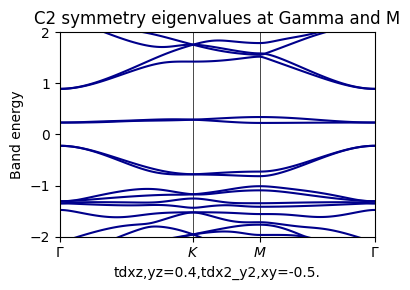

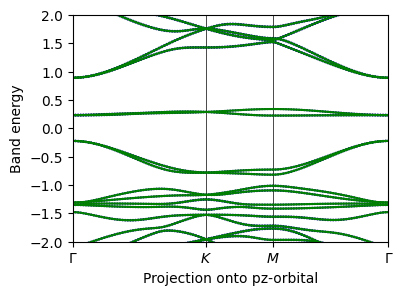

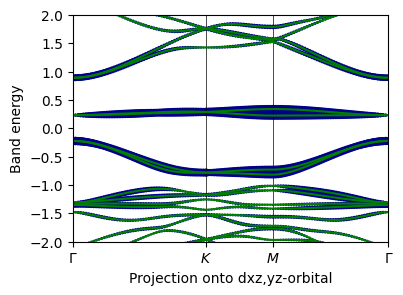

In [35]:
nk = 121

def hex_path_spectrum(nk):
    #basis vectors in k space
    #k_graph = np.linalg.inv(lat).T
    k_mega_lat = np.dot(k_graph.T,np.linalg.inv(coef)).T

    k_list     = np.array([[0.,0.],[1./3.,2./3.],[.5,.5],[0.,0.]])
    #k_list     = np.array([[.5,.5],[0.,0.],[1./3.,2./3.],[.5,.5]])


    n_nodes  = k_list.shape[0]
    k_node   = np.zeros(n_nodes,dtype=float)
    k_metric = np.linalg.inv(np.dot(mega_lat,mega_lat.T))

    for n in range(1,n_nodes):
        dk = k_list[n]-k_list[n-1]
        dklen = np.sqrt(np.dot(dk,np.dot(k_metric,dk)))
        k_node[n] = k_node[n-1]+dklen



    node_index = [0]
    for n in range(1,n_nodes-1):
        frac = k_node[n]/k_node[-1]
        node_index.append(int(round(frac*(nk-1))))
    node_index.append(nk-1)



    k_dist = np.zeros(nk,dtype=float)
    #   array listing the interpolated k-points
    k_vec  = np.zeros((nk,2),dtype=float)

    # go over all kpoints
    k_vec[0] = k_list[0]
    for n in range(1,n_nodes):
        n_i  = node_index[n-1]
        n_f  = node_index[n]
        kd_i = k_node[n-1]
        kd_f = k_node[n]
        k_i  = k_list[n-1]
        k_f  = k_list[n]
        for j in range(n_i,n_f+1):
            frac = float(j-n_i)/float(n_f-n_i)
            k_dist[j] = kd_i+frac*(kd_f-kd_i)
            k_vec[j]  = k_i+frac*(k_f-k_i)


    label = (r'$\Gamma $',r'$K$', r'$M$', r'$\Gamma $')
    #label = (r'$M $',r'$\Gamma$', r'$K$', r'$M $')

    evals = np.array(hex_energy_bands(k_vec)).T
    #evals= np.array(eff_bands(imp1,imp2,k_vec,delimp)).T

    fig, ax = plt.subplots(figsize=(4,3))
    # specify horizontal axis details
    # set range of horizontal axis
    ax.set_xlim(k_node[0],k_node[-1])
    # put tickmarks and labels at node positions
    ax.set_xticks(k_node)
    ax.set_xticklabels(label)
    # add vertical lines at node positions
    for n in range(len(k_node)):
      ax.axvline(x = k_node[n],linewidth=0.5, color='k')
    # put title
    ax.set_title('tdxz,yz='+str(td)+',tdx2_y2,xy='+str(tdsqrt)+'.')
    ax.set_title('C2 symmetry eigenvalues at Gamma and M')
    ax.set_xlabel('tdxz,yz='+str(td)+',tdx2_y2,xy='+str(tdsqrt)+'.')
    ax.set_ylabel("Band energy")
    mega_size = len(mega_orbits)
    # plot first and second band
    for g in range(mega_size):
    #for g in range(6):
        ax.plot(k_dist,evals[g],color='darkblue')
    #ax.plot(k_dist,evals[24],color='green')

    #for i, txt in enumerate(C2_Gamma_list[1]):
        #ax.annotate(round(txt,1), (k_dist[1],C2_Gamma_list[0][i] ))

    #for i, txt in enumerate(C2_M_list[1]):
        #ax.annotate(np.real(round(txt,1)), (k_dist[75],C2_M_list[0][i] ))

    fig.tight_layout()
    plt.ylim(-2.,2.)
    #fig.savefig('PBC_bands.pdf')

    plt.show()

    return
hex_path_spectrum(nk)


def bands_eigenvecs(k_vec):
    eval_list = []
    evec_list = []
    for k in k_vec:
        eval,evec  = np.linalg.eigh(hex_tb_ham(k,mega_orbits),UPLO='L')
        evec = evec.T
        #print('K-VALUE',k)
        #print(evec)
        eval_list.append(eval)
        evec_list.append(evec)
    return {'evals':eval_list,'evecs':evec_list}


#the projected_orbital variable can take values 'pz', 'dxz,yz', 'dxy,x2_y2'
def project_path_spectrum(nk,projected_orbit):
    k_mega_lat = np.dot(k_graph.T,np.linalg.inv(coef)).T
    k_list     = np.array([[0.,0.],[1./3.,2./3.],[.5,.5],[0.,0.]])

    n_nodes  = k_list.shape[0]
    k_node   = np.zeros(n_nodes,dtype=float)
    k_metric = np.linalg.inv(np.dot(mega_lat,mega_lat.T))

    for n in range(1,n_nodes):
        dk = k_list[n]-k_list[n-1]
        dklen = np.sqrt(np.dot(dk,np.dot(k_metric,dk)))
        k_node[n] = k_node[n-1]+dklen

    node_index = [0]
    for n in range(1,n_nodes-1):
        frac = k_node[n]/k_node[-1]
        node_index.append(int(round(frac*(nk-1))))
    node_index.append(nk-1)

    k_dist = np.zeros(nk,dtype=float)
    k_vec  = np.zeros((nk,2),dtype=float)


    k_vec[0] = k_list[0]
    for n in range(1,n_nodes):
        n_i  = node_index[n-1]
        n_f  = node_index[n]
        kd_i = k_node[n-1]
        kd_f = k_node[n]
        k_i  = k_list[n-1]
        k_f  = k_list[n]
        for j in range(n_i,n_f+1):
            frac = float(j-n_i)/float(n_f-n_i)
            k_dist[j] = kd_i+frac*(kd_f-kd_i)
            k_vec[j]  = k_i+frac*(k_f-k_i)


    label = (r'$\Gamma $',r'$K$', r'$M$', r'$\Gamma $')
    evals = np.array(bands_eigenvecs(k_vec)['evals']).T
    evecs = np.array(bands_eigenvecs(k_vec)['evecs'])


    pz  = []
    dxz = []
    dxy = []

    for eigenvecs in evecs:
        all_amp = orbit_projector(eigenvecs)
        set_pz  = []
        set_dxz = []
        set_dxy = []
        for one_amp in all_amp:
            set_pz.append(one_amp[0])
            set_dxz.append(one_amp[1])
            set_dxy.append(one_amp[2])
        pz.append(set_pz)
        dxz.append(set_dxz)
        dxy.append(set_dxy)


    mega_size = len(mega_orbits)


    dxz_final = np.array(dxz).T*50
    dxy_final = np.array(dxy).T*50
    pz_final = np.array(pz).T*50

    #for i in range(10):
    #    print('band_number',i,dxz_final[i])

    fig, ax = plt.subplots(figsize=(4,3))

    ax.set_xlim(k_node[0],k_node[-1])
    ax.set_xticks(k_node)
    ax.set_xticklabels(label)
    for n in range(len(k_node)):
      ax.axvline(x = k_node[n],linewidth = 0.5, color='k')
    if projected_orbit == 0:
        ax.set_xlabel("Projection onto pz-orbital")
    if projected_orbit == 1:
        ax.set_xlabel("Projection onto dxz,yz-orbital")
    if projected_orbit == 2:
        ax.set_xlabel("Projection onto dxy,x2_y2-orbital")
    ax.set_ylabel("Band energy")



    mega_size = len(mega_orbits)
    for g in range(mega_size):
        if projected_orbit == 0:
            plot_list = pz_final
        if projected_orbit == 1:
            plot_list = dxz_final
        if projected_orbit == 2:
            plot_list = dxy_final
        if projected_orbit != 0 and projected_orbit != 1 and projected_orbit != 2:
            print('the projected_orbital variable can take values ''pz''--0, ''dxz,yz''--1, ''dxy,x2_y2--2')
        ax.scatter(k_dist, evals[g],s = plot_list[g],color='darkblue')
        ax.plot(k_dist,evals[g],color='g')

    fig.tight_layout()
    plt.ylim(-2.0,2.0)
    #fig.savefig('hex_unitcell_bands.pdf')
    plt.show()
    return

project_path_spectrum(nk,0)
project_path_spectrum(nk,1)
project_path_spectrum(nk,2)


## OBC spectrum

Number of unitcells =  61
This is C_6 symmetric the graphene flake 


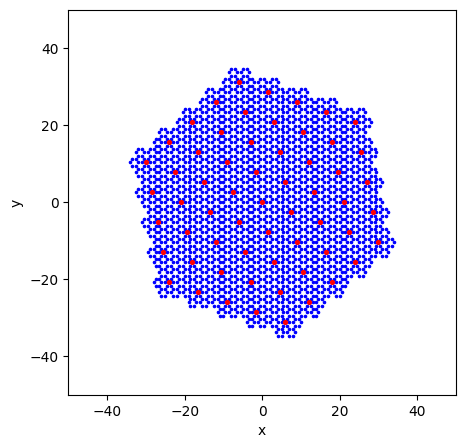

In [42]:
#------------------------------------------------------------------------OBC spectrum
eigen_values_together = []
size_list = []
for levels in [int(levels-1),int(levels)]:
    hoppings_inside = []
    hoppings_neigh  = []
    for hop in hoppings:
        if hop[2]  != [0,0]:
            hoppings_neigh.append(hop)
        else:
            hoppings_inside.append(hop)


def unit_cell_tb(orb):
    unit_size  = len(orb)
    tb_ham     = np.zeros((unit_size,unit_size), dtype=complex)
    for i in range(unit_size):
        tb_ham[i,i] = onsite
    for s in onsites:
        tb_ham[s,s] += delta
    for hop in hoppings_inside:
        i = int(hop[0])
        j = int(hop[1])
        amp   = t
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    for d in d_hops:
        i = int(d[0])
        j = int(d[1])
        amp   = d[2]
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    for dsqrt in dsqrt_hops:
        i = int(dsqrt[0])
        j = int(dsqrt[1])
        amp   = dsqrt[2]
        tb_ham[i,j] += amp
        tb_ham[j,i] += amp.conjugate()
    tb_ham[unit_size-4,unit_size-4] = dx_onsite
    tb_ham[unit_size-3,unit_size-3] = dy_onsite
    tb_ham[unit_size-2,unit_size-2] = dxsqrt_onsite
    tb_ham[unit_size-1,unit_size-1] = dxy_onsite
    return tb_ham

corners_list = levels*np.array([[1,0],[0,1],[-1,1],[-1,0],[0,-1],[1,-1],[1,0]])
corners_loc  = [cartez_coord(i,mega_lat) for i in list(corners_list)]
path_corn    = mpltPath.Path(corners_loc)


def insider_check(pnt, path , ends):
    if path.contains_points([pnt],radius = 1e-9) == True:
        return True
    else:
        return False

list_inside   = []
for gen_point in grid:
    if insider_check(cartez_coord(gen_point,lat), path_hex, hex_loc) == True:
        list_inside.append(gen_point)

def grid_generator(levels):
    expand = []
    group1 = np.arange(-levels,levels+1,1)
    check_len    = np.sqrt(mega_lat[0][0]**2 + mega_lat[0][1]**2 )
    y_length     = cartez_coord([1,1],mega_lat)
    check_y      = np.sqrt(y_length[0]**2 + y_length[1]**2 )
    expand_check = list(itertools.product(group1, group1))
    for el in expand_check:
        tmp = cartez_coord(el,mega_lat)
        if insider_check(tmp, path_corn, corners_loc) == True:
            expand.append(list(el))
        #if np.sqrt(tmp[0]**2+tmp[1]**2) <= levels*check_len :
            #and -levels/2*check_y<= tmp[1] <= levels/2*check_y
            #expand.append(list(el))
    return expand

expand = grid_generator(levels)

print('Number of unitcells = ', len(expand))

hex_grid  = []
grid_list = []
for span in expand:
    for orbit in mega_orbits:
            tmp = orbit + span
            grid_list.append(np.array(tmp))
hex_grid  = np.array(grid_list)



tb_unit_hexagon = unit_cell_tb(mega_orbits)
final_hex       = block_diag(*([tb_unit_hexagon] * (len(expand))))


def orbit_localizer(cell_loc,orbit_loc):
    number_inexpand  = expand.index(list(cell_loc))
    new_loc = number_inexpand * len(mega_orbits) + orbit_loc
    return new_loc


inter_hoppings = []
for unit in expand:
    for hop_el in hoppings_neigh:
        one_neighb     = [sum(x) for x in zip(list(unit), hop_el[2])]
        inv_one_neighb = [x-y for x,y in zip(list(unit), hop_el[2])]
        if any(one_neighb == local for local in expand):
            i_value = orbit_localizer(list(unit),hop_el[0])
            j_value = orbit_localizer(one_neighb,hop_el[1])
            tmp1 = [i_value,j_value]
            #print(unit,one_neighb,tmp1)
            tmp2 = [j_value,i_value]
            inter_hoppings.append(tmp1)
            inter_hoppings.append(tmp2)
            final_hex[i_value,j_value] = t
            final_hex[j_value,i_value] = t


def hermitian_check(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if np.transpose(matrix)[i,j] == matrix[i,j]:
                print('hermitian')
            else:
                print('NOT')
#hermitian_check(final_hex)

def super_lattice_drawer(inter_hoppings,grid):

    fig,ax = plt.subplots(figsize=(5,5))

    grid_cartez = [cartez_coord(i,mega_lat) for i in hex_grid]
    x_vals = np.array([grid_cartez[i][0] for i in range(len(grid_cartez))])
    y_vals = np.array([grid_cartez[i][1] for i in range(len(grid_cartez))])
    ax.scatter(x_vals, y_vals, marker='.',s= 10,color='b')

    imp_only = []
    for span in expand:
        tmp = mega_orbits[43] + span
        imp_only.append(np.array(tmp))
    imp_only  = np.array(imp_only)
    grid_cartez = [cartez_coord(i,mega_lat) for i in imp_only]
    x_vals = np.array([grid_cartez[i][0] for i in range(len(grid_cartez))])
    y_vals = np.array([grid_cartez[i][1] for i in range(len(grid_cartez))])
    ax.scatter(x_vals, y_vals, marker='.',s= 30,color='r')


    #start  = [r[0] for r in hex_grid]
    #finish = [r[1] for r in hex_grid]
    #for i in range(len(hex_grid)):
        #ax.annotate(i, (start[i], finish[i]))



    #for hop in inter_hoppings:
    #    start=[x_vals[hop[0]],x_vals[hop[1]]]
    #    finish=[y_vals[hop[0]],y_vals[hop[1]]]
    #    ax.plot(start,finish,'.-',color='b')
    #start  = [r[0] for r in hex_loc]
    #finish = [r[1] for r in hex_loc]
    #plt.plot(start,finish,'ro-',color='b',markersize=2)
    #for i in range(len(hex_loc)):
    #    ax.annotate(i, (start[i], finish[i]))




    #start  = [r[0] for r in inside_hexagon]
    #finish = [r[1] for r in inside_hexagon]
    #for i in range(len(inside_hexagon)):
    #    ax.annotate(i, (start[i], finish[i]))


    #ax.scatter(mega_lat[0][0],mega_lat[0][1],color='g',marker='s')
    #ax.scatter(mega_lat[1][0],mega_lat[1][1],color='g',marker='s')
    #ax.scatter(0.,0.,color='g',marker='s')



    plt.ylabel('y')
    plt.xlabel('x')
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    #plt.savefig('hexagon_latticeOBC.pdf')
    return plt.show()


print('This is C_6 symmetric the graphene flake ')
super_lattice_drawer(inter_hoppings,grid)


Last occupied state: 0.6355915941059088
Number of degenerate states:  6
Fermi energy: 0.7
Number of states below Fermi level: 6
Number of pz/2+d_orbitals in all unit cells: 1525.0
Total number of states: 2806
The corner modes themselves.


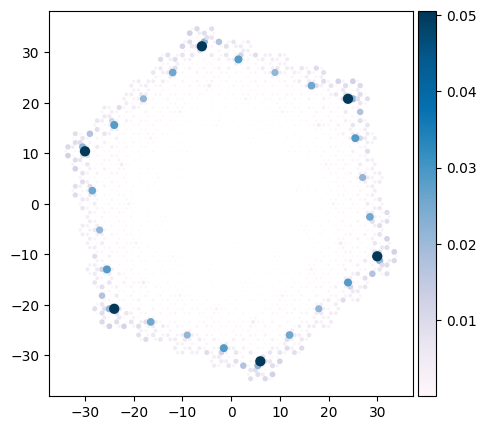

In [45]:
#file = open("energy_list_OBC.txt","w")

#file.write(len(expand))
eigen_values, eigen_vectors = np.linalg.eigh(final_hex,UPLO='L')
eigen_values_together.append(eigen_values)
size_list.append(len(expand))
eigen_vectors = eigen_vectors.T


file = open("energy_list_OBC.txt","w")
for i in eigen_values_together:
    for l in i:
        if l != i[-1]:
            file.write(str(l)+',')
        if l == i[-1]:
            file.write(str(l))
    file.write('\n')
file.close()


en_fermi = eigen_values[int((len(mega_orbits)-4)*len(expand)/2+4*len(expand))-1]
#print('last_occupied level',int(42*len(expand)/2+4*len(expand))-1)
print('Last occupied state:',en_fermi)
nk = 121

def states_localizer(energy_window):
    energies = []
    vectors_in_window =[]
    for eigen_val in eigen_values:
        if energy_window[0] < eigen_val < energy_window[1]:
            n = eigen_values.tolist().index(eigen_val)
            #print('voila: state-energy=',eigen_val,';  state-number=',i)
            energies.append(eigen_val)
            vec_appending=[np.abs(x)**2 for x in eigen_vectors[n]]
            vectors_in_window.append(np.array(vec_appending).flatten())
    return {'energies':energies,'vecs_in_window':vectors_in_window}
def window_drawer(energies):
    i = 0
    for eigen_val in energies:
        i += 1
        print('voila: corner-state-energy=',eigen_val,';  state-number=',i)
        plt.scatter(1., eigen_val,marker='_',color='b')
    start  = [1 for r in energies]
    finish = [r for r in energies]
    for i in range(len(energies)):
        plt.annotate(i, (start[i], finish[i]))
    plt.scatter(1., en_fermi ,marker='_',color='r')
    plt.ylabel('energy')
    plt.xlabel('-')
    plt.xlim(0,2)
    plt.ylim(energy_window[0],energy_window[1])
    plt.show()
    return


energy_window     = [0.6, 0.7]
vectors_in_window = states_localizer(energy_window)['vecs_in_window']
energies          = states_localizer(energy_window)['energies']

#Uncomment for plotting energy levels inside the gap that give corner modes. 
#window_drawer(energies)

#print(energies)


vec_todraw = []
for vec in vectors_in_window:
    new_vec = []
    for n in range(len(expand)):
        d_set   = []
        for i in range(4):
            d_set.append(vec[len(mega_orbits)*n+len(mega_orbits)-4+i])
        for i in range(len(mega_orbits)-4):
            new_vec.append(vec[len(mega_orbits)*n+i])
        new_vec.append(sum(d_set))
    vec_todraw.append(new_vec)



def states_drawer(state_num):
    fig,ax = plt.subplots(figsize=(10,10))

    hex_grid  = []
    grid_list = []
    for span in expand:
        for orbit in mega_orbits[:-3]:
                tmp = orbit + span
                grid_list.append(np.array(tmp))
    hex_grid    = np.array(grid_list)

    grid_cartez = [cartez_coord(i,mega_lat) for i in hex_grid]
    x_vals = np.array([grid_cartez[i][0] for i in range(len(grid_cartez))])
    y_vals = np.array([grid_cartez[i][1] for i in range(len(grid_cartez))])
    #ax.scatter(x_vals, y_vals, marker='.',color='b')


    vecs_to_draw = np.array(vec_todraw)*len(mega_orbits)*30


    ax.scatter(x_vals, y_vals,s = vecs_to_draw[state_num],color='b')



    plt.ylabel('y')
    plt.xlabel('x')
    plt.xlim(-50,50)
    plt.ylim(-50,50)

    plt.title('This is amp^2 of state with energy'+str(energies[state_num]))
    #plt.savefig('state-plot'+str(state_num)+'.pdf')
    return plt.show()


#for i in range(len(vectors_in_window)):
    #states_drawer(i)

en_fermi = 0.7

def occupied_states(eigen_values):
    energies = []
    vectors_in_window = []
    for eigen_val in eigen_values:
        if  0.6 < eigen_val <= en_fermi:
            n = eigen_values.tolist().index(eigen_val)
            energies.append(eigen_val)
            vec_appending = [np.abs(x) for x in eigen_vectors[n]]
            vectors_in_window.append(np.array(vec_appending).flatten())
    return {'energies':energies,'vecs_in_window':vectors_in_window}

#vectors_in_window = occupied_states(eigen_values)['vecs_in_window']
#energies          = occupied_states(eigen_values)['energies']

np.savetxt('cornerstates_evals_{}.txt'.format(int(levels)),energies,fmt='%0.17f',delimiter=',')

file = open("cornerstates_evecs_{}.txt".format(int(levels)),"w")
for i in vectors_in_window:
    for l in i:
        if l != i[-1]:
            file.write(str(l)+',')
        if l == i[-1]:
            file.write(str(l))
    file.write('\n')
file.close()


cornvec2 = [0.5*sum(x) for x in zip(vectors_in_window[1],vectors_in_window[2])]
cornvec3 = [0.5*sum(x) for x in zip(vectors_in_window[3],vectors_in_window[4])]
vectors_in_window = [vectors_in_window[0],cornvec2,cornvec3,vectors_in_window[5]]



vec_todraw = []

for vec in vectors_in_window:
    new_vec = []
    for n in range(len(expand)):
        d_set   = []
        for i in range(4):
            d_set.append(vec[len(mega_orbits)*n+len(mega_orbits)-4+i])
        for i in range(len(mega_orbits)-4):
            new_vec.append(vec[len(mega_orbits)*n+i])
        new_vec.append(sum(d_set))
    vec_todraw.append(new_vec)

average_cells = []
for vec in vec_todraw:
    subvec  = []
    for i in range(len(expand)):
        tmp_vec = []
        for j in range(len(mega_orbits)-3):
            tmp_vec.append(vec[i*(len(mega_orbits)-3)+j])
        subvec.append(sum(tmp_vec))
    average_cells.append(subvec)

print('Number of degenerate states: ',len(energies))
print('Fermi energy:',en_fermi)
print('Number of states below Fermi level:',len(energies))
print('Number of pz/2+d_orbitals in all unit cells:',((len(mega_orbits)-4)/2+4)*len(expand))
print('Total number of states:',(len(mega_orbits)*len(expand)))

print('The corner modes themselves.')

def occ_states_drawer(hex_grid):
    amp_sqrt = [sum(x) for x in zip(*vec_todraw)]
    fig, ax = plt.subplots(figsize=(5,5))
    #fig, (ax1, ax) = plt.subplots(1, 2, figsize=[10, 5])

    hex_grid  = []
    grid_list = []
    for span in expand:
        for orbit in mega_orbits[:-3]:
                tmp = orbit + span
                grid_list.append(np.array(tmp))
    hex_grid    = np.array(grid_list)

    #np.savetxt('coord_lattice.txt',hex_grid,fmt='%0.17f',delimiter=',')


    grid_cartez = [cartez_coord(i,mega_lat) for i in hex_grid]
    x_vals = np.array([grid_cartez[i][0] for i in range(len(grid_cartez))])
    y_vals = np.array([grid_cartez[i][1] for i in range(len(grid_cartez))])
    #ax.scatter(x_vals, y_vals, marker='.',color='b')

    #vecs_to_draw = np.array(vectors_in_window)*len(mega_orbits)*len(mega_orbits)*10

    #below is when amplitudes in the band around zero energy are all summed so we expect uniformly spread amplitude of probability
    vecs_to_draw = np.array(amp_sqrt)


    x_list = x_vals
    y_list = y_vals
    C_I_list = vecs_to_draw
    n = 300

    grid_x, grid_y = np.meshgrid(np.linspace(min(x_list),max(x_list),n),np.linspace(min(y_list),max(y_list),n))


    points = np.array([np.array([i,j]) for (i,j) in zip(x_vals,y_vals)])
    grid_z2 = griddata(points, vecs_to_draw, (grid_x, grid_y), method='linear')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    #uncomment this cax if you want to customize the sidebar
    #cax = inset_axes(ax,
    #               width="5%",  # width = 5% of parent_bbox width
    #               height="100%",  # height : 50%
    #               loc='upper left',
    #               bbox_to_anchor=(1.01, 0., 1, 1),
    #               bbox_transform=ax.transAxes,
    #               borderpad=0.0
    #               )
    im = ax.scatter( x_vals, y_vals,s = vecs_to_draw*800, c=vecs_to_draw, cmap = 'PuBu', alpha =1.0)
    fig.colorbar(im,cax=cax)
    #plt.savefig('LDOS_ver3'+str(len(expand))+'.pdf')
    return plt.show()
occ_states_drawer(hex_grid)


